## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Code

In [3]:
historico_ibovespa_df = pd.read_csv("bases/History_Ibovespa_2014-2024.csv",
                                    sep=',',
                                    parse_dates=['Data'],
                                    index_col='Data'
                                    )

/tmp/ipykernel_3029/1782552752.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  historico_ibovespa_df = pd.read_csv("bases/History_Ibovespa_2014-2024.csv",


In [4]:
historico_ibovespa_df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-06-28,123.907,124.308,124.500,123.298,"9,07M","-0,32%"
2024-06-27,124.308,122.642,124.308,122.642,"8,71M","1,36%"
2024-06-26,122.641,122.331,122.701,121.402,"8,18M","0,25%"
2024-06-25,122.331,122.634,122.849,121.997,"6,94M","-0,25%"
2024-06-24,122.637,121.343,122.840,121.307,"7,84M","1,07%"


In [5]:
historico_ibovespa_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2600 entries, 2024-06-28 to 2014-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    2600 non-null   float64
 1   Abertura  2600 non-null   float64
 2   Máxima    2600 non-null   float64
 3   Mínima    2600 non-null   float64
 4   Vol.      2599 non-null   object 
 5   Var%      2600 non-null   object 
dtypes: float64(4), object(2)
memory usage: 142.2+ KB


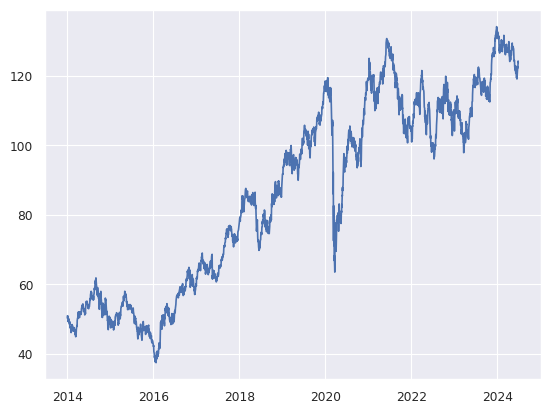

In [6]:
sns.set_theme('paper')
plt.plot(historico_ibovespa_df.index, historico_ibovespa_df.Último)
plt.show()

In [7]:
historico_ibovespa_df['Último']

Data
2024-06-28    123.907
2024-06-27    124.308
2024-06-26    122.641
2024-06-25    122.331
2024-06-24    122.637
               ...   
2014-01-08     50.577
2014-01-07     50.430
2014-01-06     50.974
2014-01-03     50.981
2014-01-02     50.341
Name: Último, Length: 2600, dtype: float64

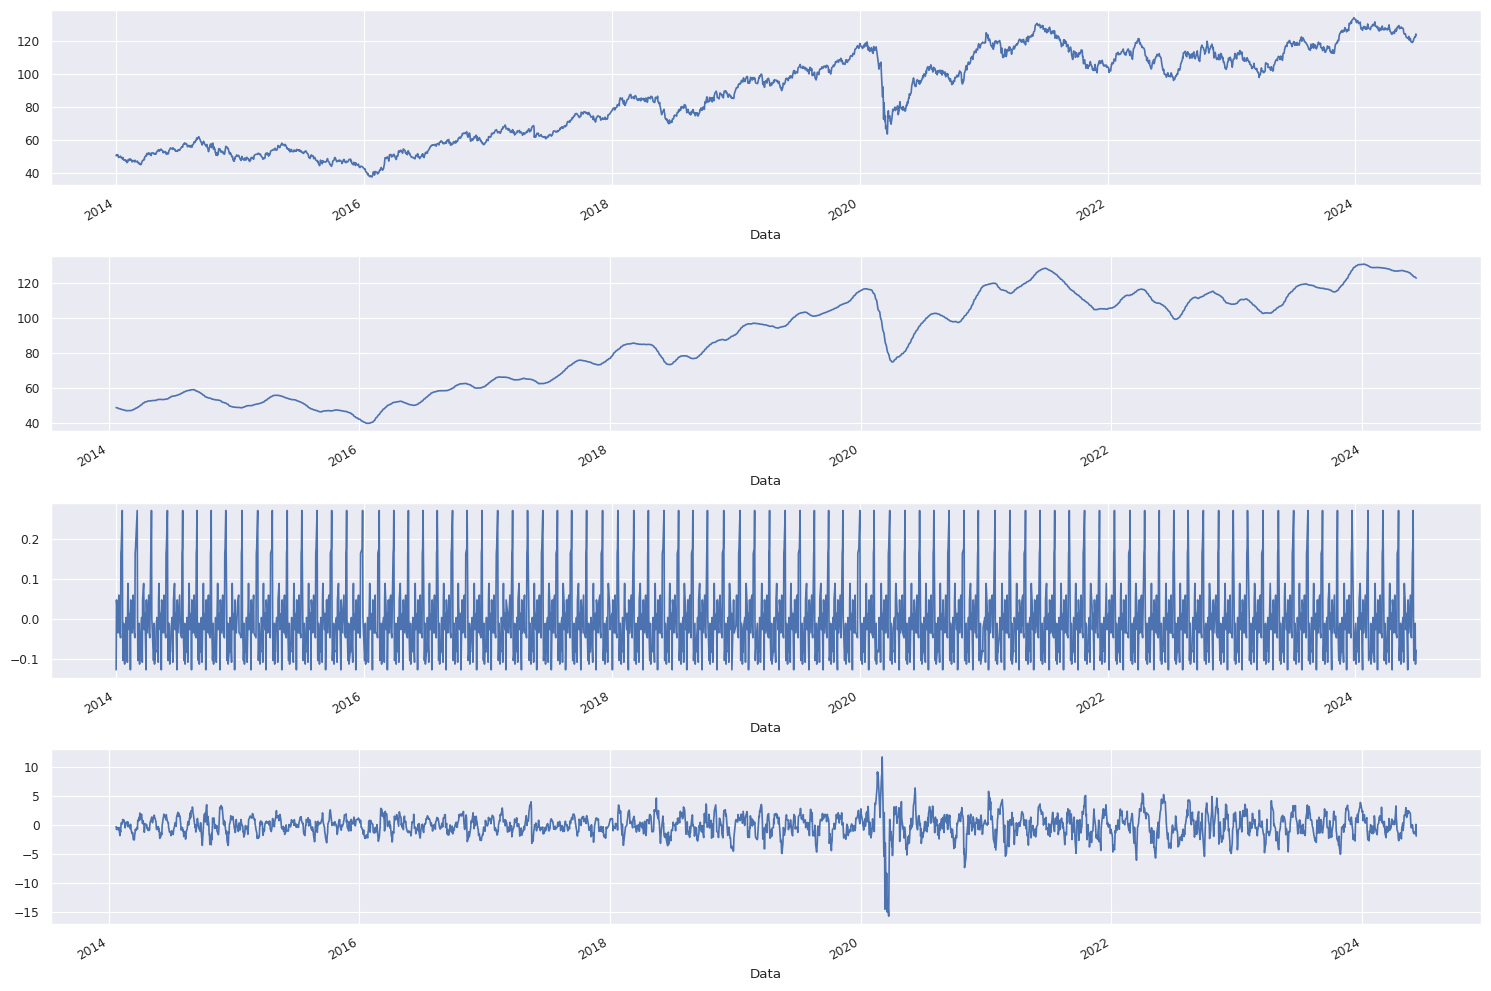

In [11]:
ibovespa_ultimo_df = historico_ibovespa_df['Último']

results = seasonal_decompose(ibovespa_ultimo_df, period=30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (15,10))

results.observed.plot(ax=ax1)
results.trend.plot(ax=ax2)
results.seasonal.plot(ax=ax3)
results.resid.plot(ax=ax4)

plt.tight_layout()